In [1]:
import numpy as np
import open3d as o3d
import copy
from matplotlib import pyplot as plt

In [2]:
from readData import *
from showFig import *
from showCloud import *
from warp import *

In [3]:
def draw_transform(src, tgt, T):
    srct = copy.deepcopy(src)
    tgtt = copy.deepcopy(tgt)
    srct.paint_uniform_color([1, 0.5, 0])
    tgtt.paint_uniform_color([0, 0.5, 0.9])
    srct.transform(T)
    o3d.visualization.draw_geometries([srct, tgtt])
    return src.transform(T)

In [4]:
def preprocess(pcd, voxel_size):
    pcd_down = pcd.voxel_down_sample(voxel_size)
    radius_normal = voxel_size * 2
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30)
    )

    radius_feature = voxel_size * 50
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100)
    )
    print(pcd_fpfh.data.mean())
    # print(pcd_fpfh.data.max())
    return pcd_down, pcd_fpfh 

In [5]:
points0, mat0 = getPoints("..\dataset\scan0.npy", prange=(200, 150, (-100, -30)), skip=20)
points1, mat1 = getPoints("..\dataset\scan2.npy", prange=(200, 150, (-100, -30)), skip=20)

read in ..\dataset\scan0.npy
x range: -197 ~ 198
y range: -153 ~ 145
z range: -66 ~ 0
read in ..\dataset\scan2.npy
x range: -197 ~ 1326
y range: -1076 ~ 145
z range: -10150 ~ 365


In [43]:
voxel_size = 0.1
src = o3d.geometry.PointCloud()
src.points = o3d.utility.Vector3dVector(points0)
tgt = o3d.geometry.PointCloud()
tgt.points = o3d.utility.Vector3dVector(points1)
# o3d.visualization.draw_geometries([src, tgt])
srcd, srcf = preprocess(src, voxel_size)
tgtd, tgtf = preprocess(tgt, voxel_size)

18.181818181818183
18.181301344552146


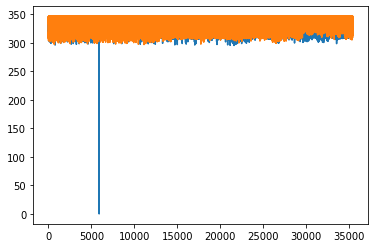

In [44]:
scale0 = np.linalg.norm(tgtf.data, axis=0)
plt.plot(list(range(len(scale0))), scale0)
scale1 = np.linalg.norm(srcf.data, axis=0)
plt.plot(list(range(len(scale1))), scale1)
plt.show()

In [8]:
color = np.zeros((scale1.shape[0],3))
srcc = color.copy()
srcc[:,0] = 1-(scale1-scale1.min())/(scale1.max()-scale1.min())
srcd.colors = o3d.utility.Vector3dVector(srcc)
o3d.visualization.draw_geometries([srcd])

In [52]:
def showFeature(pcd, pcdf, eps=0.6):
    scale = np.linalg.norm(pcdf.data, axis=0)
    # plt.plot(list(range(len(scale0))), scale0)
    # plt.show()
    pcdc = np.hstack([np.asarray(pcd.points), scale.reshape(-1,1)])
    pcdc = pcdc[(scale>=300) & (scale<=350)]
    pcdc[:,3] = 1-(pcdc[:,3]-pcdc[:,3].min())/(pcdc[:,3].max()-pcdc[:,3].min())
    pcdc[:,3][pcdc[:,3]<eps] = 0 
    print(pcdc.shape)
    return pcdc

In [38]:
def filterFeature(pcd, pcdf, eps=0.5):
    scale = np.linalg.norm(pcdf.data, axis=0)
    pcdc = np.hstack([np.asarray(pcd.points), pcdf.data.swapaxes(0,1), scale.reshape(-1,1)])
    pcdc = pcdc[(scale>=300) & (scale<=350)]
    pcdc[:,-1] = 1-(pcdc[:,-1]-pcdc[:,-1].min())/(pcdc[:,-1].max()-pcdc[:,-1].min())
    pcdc = pcdc[pcdc[:,-1]>eps]
    return pcdc[:, :-1]

In [57]:
src_data = filterFeature(srcd, srcf)
tgt_data = filterFeature(tgtd, tgtf)

In [53]:
srcc = showFeature(srcd, srcf)
tgtc = showFeature(tgtd, tgtf)

(35390, 4)
(35132, 4)


In [54]:
fig = dynVisual([srcc, tgtc], ["src", "tgt"], 0.5, 4)
fig.write_html("cloudpoint.html")

In [55]:
fig = dynVisual([srcc], ["src"], 0.5, 4)
fig.write_html("cloudsrc.html")

In [56]:
fig = dynVisual([tgtc], ["tgt"], 0.5, 4)
fig.write_html("cloudtgt.html")

In [109]:
result = o3d.pipelines.registration.registration_fast_based_on_feature_matching(
    srcd, tgtd,
    srcf, tgtf
)
draw_transform(srcd, tgtd, result.transformation)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


PointCloud with 35414 points.

In [58]:
srcf

Feature class with dimension = 33 and num = 35414
Access its data via data member.